### Pilot Bootstrap for LTP RCA EEG

In [1]:
# load packages
import numpy as np 
import scipy.io
from scipy.fft import fft, ifft
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
np.random.seed(9191977) # set seed number

In [2]:
# Main Directory of processed file from MatLab
MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\RCA\\' # set dir
SaveFigDir = 'D:\\AttnXV3_analysis\\F1NRushPlots\\' # set dir where imgs will be saved
os.chdir(MainDir)
# Set File Name 
d = os.listdir(MainDir) # list files in dir
FileN = (d[0]) # choose one
file_path = os.path.join(MainDir, FileN) # join paths and prep 2 load
print(file_path) # does path exist ... ?
print(os.path.exists(file_path)) # yes or no
print(SaveFigDir) 
print(os.path.exists(SaveFigDir))

D:\AttnXV3_analysis\RCA_F1\RCA\rcaResults_Sweep_contrast_sweeps.mat
True
D:\AttnXV3_analysis\F1NRushPlots\
True


#### Set Global Params

In [3]:
NumBins = 6 # number of contrasts
NumHarms = 2 # number of harmonic data: 2F1, 4F1
NumComp = 0 # first component from RCA
contrast_levels = np.array([1, 3, 5, 16, 40, 100])
soi = 21 # subjects data to look at 
NumBoots = 2000 # number of shuffling arrays we will have and then plot

#### Functions 

In [4]:
def CleanRCA(x): # replace 0's in data with nan's
    x[x == 0] = np.nan
    return x
##############################################################################
# shuffle data before real and imaginary numbers are combined
def ShuffleTrials(x, NumComp):
    x = np.array(x) # set data as array
    x = x[:,NumComp,:] # get # component we want
    shuff_data = np.ones_like(x) # copy of 24 x 78
    [NumRows, NumTrials] = x.shape # 24 x 78
    TrialInd = np.array(np.arange(0,NumTrials,1)) # array =len of #Trials
    #index = np.random.shuffle(TrialInd)  # random sampling without replacement - just shuffling 
    index = np.random.randint(0,NumTrials,NumTrials) # index position (# trial) # random sampling with replacement 
    NewTrialList = TrialInd[index] # shuffled pos array
    shuff_data = x[:,NewTrialList] # set rando samp w replacment
    return shuff_data # 24 x 78 array (only want 1st rca component)
################################################################################
# comine real and imaginary numbers after shuffling, only 1st component
def CombineRealImg(x, NumHarms):
    [NumCols, NumTrials] = np.shape(x) # 24 x 78-80
    DomainCutoff = int(NumCols/NumHarms) # use to index cutoff  - float -> int
    CondCutoff = int(NumTrials/2) # 39 - 40 depends...
    pre = x[:,:CondCutoff] # 24 x 39 - 40 depends ...
    post = x[:,CondCutoff:]
    AmpPerBin = np.ones((DomainCutoff,NumHarms)) # [bins (2f1 then 4f1)] X [pre /post] \ 12 x 2
    for RowInd in range(DomainCutoff):
        ################ combining data generated from real and imaginary comp (1st half of cols and last half)
        AmpPerBin[RowInd,0] = np.hypot(np.nanmean(pre[RowInd,:]),np.nanmean(pre[RowInd+DomainCutoff,:])) # 12 x 78 PRE
        AmpPerBin[RowInd,1] = np.hypot(np.nanmean(post[RowInd,:]),np.nanmean(post[RowInd+DomainCutoff,:])) # 12 x 78 POST
    return AmpPerBin
#################################################################################

### Load data

In [86]:
mat_data = scipy.io.loadmat(file_path)
rca = mat_data['rcaResult']['projectedData'][0,0]
rcaData = [rca[i,0] for i in range(rca.shape[0])] # final data output

In [134]:
# Get subject names
SubNames = mat_data['rcaResult'][0,0][5]
FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]]
print(len(FileName))
print(FileName[4])


55
2653_attnL_20231009_1015


### Step 1: Replace 0's with Nan's

In [9]:
rca = dict()
for k in range(len(rcaData)):
    rca[k] = CleanRCA(rcaData[k])

### Step 2 : Shuffle Data Across Trials

In [10]:
shuffs = dict()
for j in range(NumBoots):
    shuffs[j] = ShuffleTrials(rca[soi], NumComp)
    #print(shuffs[j][0,0:2])

### Step 3: Combine Real and Imaginary components from RCA Sweep
#### From Real RCA Data ...

In [11]:
y = rca[soi][:,NumComp,:] # 3 dim array
real_rca = CombineRealImg(y, NumHarms) # only takes 2 dim array
real_diff =  real_rca[:,1] - real_rca[:,0] # 12 array diff : post - pre

#### ... And Permuted Data

In [12]:
psuedo_rca = dict()
for pdata in range(len(shuffs.keys())):
    psuedo_rca[pdata] = CombineRealImg(shuffs[pdata], NumHarms) # amplitude per bin per harmonic [12 x 2]
    #print(np.shape(psuedo_rca[pdata])) # shape
    #print(psuedo_rca[pdata][0:3,0]) # data generated

### Step 4: Find difference in amplitude between Post and Pre ...
#### ... and store in big array

In [13]:
pseudo_rca_diffs = np.ones((int(len(shuffs.keys())),NumBins*2)) # iteration x difference generated from pre/postharmonic

for d in range(len(shuffs.keys())):
    data = psuedo_rca[d] # 12 x 2 
    AmpDiff_Ind = data[:,1] - data[:,0]
    pseudo_rca_diffs[d,:] = AmpDiff_Ind # 12 int array

print('Number of Iters and Bin Nums:', pseudo_rca_diffs.shape) # numIters x 12 frequency labels we have  - still 0:6 2F1, 6: 4F1

Number of Iters and Bin Nums: (2000, 12)


[ 0.32799939  0.41597075  0.83664917  0.98050464  0.6130247   0.71357014
 -0.04003149 -0.19172552 -0.00992156  0.11990477  0.6204895   0.9348629 ]
DescribeResult(nobs=2000, minmax=(-0.7893052377345355, 0.6895412777006769), mean=0.0033817225760145466, variance=0.04533518927374755, skewness=-0.01954859479370194, kurtosis=0.2640153645165979)
SEM:  0.00476104974106276


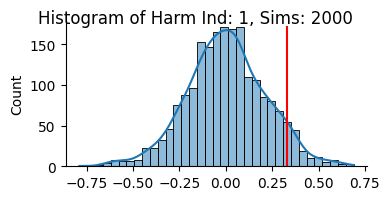

DescribeResult(nobs=2000, minmax=(-0.785483394691564, 0.9281241175994592), mean=0.0013239575982355036, variance=0.052304373956493844, skewness=0.02390770477217718, kurtosis=0.29774556795728735)
SEM:  0.005113920900663885


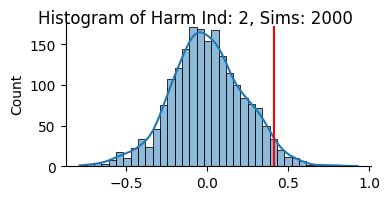

DescribeResult(nobs=2000, minmax=(-0.7815262438117703, 0.7636290838675732), mean=-0.0032380049863737336, variance=0.047872843142514214, skewness=0.045166609319071606, kurtosis=-0.0267034512682649)
SEM:  0.004892486236184738


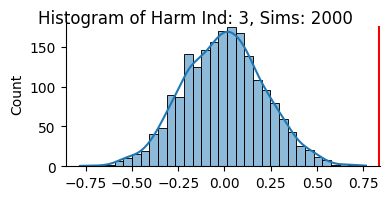

DescribeResult(nobs=2000, minmax=(-0.811883559165615, 0.8381203944079232), mean=-0.0023187738421087973, variance=0.045818545679537456, skewness=0.012831582719105712, kurtosis=-0.08805638689284256)
SEM:  0.004786363216448238


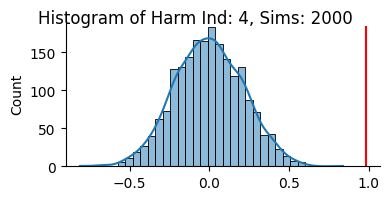

DescribeResult(nobs=2000, minmax=(-0.5343054806969558, 0.5325299710962303), mean=-0.003790721324525017, variance=0.03123903575287361, skewness=-0.016869778827454687, kurtosis=-0.13008187030190266)
SEM:  0.0039521535745004645


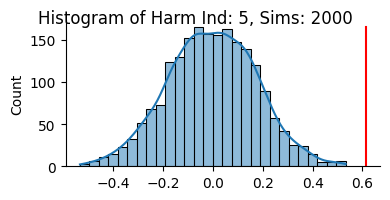

DescribeResult(nobs=2000, minmax=(-0.687703445246326, 0.7026703749279071), mean=-0.004418930736340484, variance=0.04335754680370186, skewness=0.07615266224587028, kurtosis=-0.0674624110101556)
SEM:  0.004656046971611318


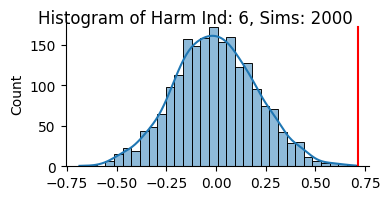

DescribeResult(nobs=2000, minmax=(-0.5309498688205263, 0.5474083331855448), mean=-0.0019244953974131944, variance=0.022629051654381893, skewness=0.015075762859748152, kurtosis=0.07610196509142808)
SEM:  0.0033637071553854012


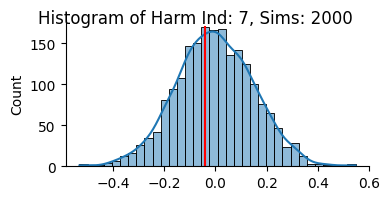

DescribeResult(nobs=2000, minmax=(-0.5094954746670864, 0.5507119749002267), mean=0.0031066435114927597, variance=0.029239349177973994, skewness=-0.021098095811029366, kurtosis=-0.003353433512872428)
SEM:  0.003823568305782832


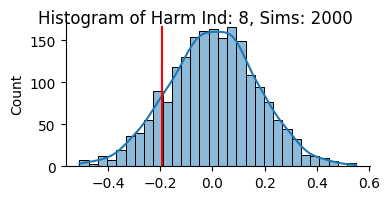

DescribeResult(nobs=2000, minmax=(-0.4232635464037158, 0.4689006262219497), mean=0.0015543980605683956, variance=0.015427422173695377, skewness=-0.06054192638264303, kurtosis=0.05031140258205502)
SEM:  0.002777356852629436


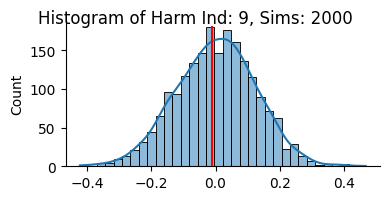

DescribeResult(nobs=2000, minmax=(-0.5548910951853414, 0.48979635837334967), mean=-0.0018263639232270355, variance=0.019468985839124826, skewness=-0.05702005097720109, kurtosis=0.11531183735137018)
SEM:  0.0031200148909199797


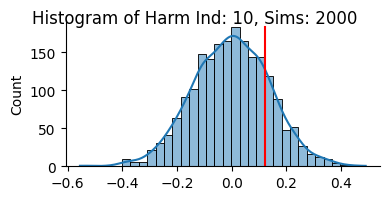

DescribeResult(nobs=2000, minmax=(-0.5041127009907846, 0.543297023800877), mean=-0.004585112660920716, variance=0.027180193719148794, skewness=0.09701307700725219, kurtosis=-0.06179853688789905)
SEM:  0.0036864748554105713


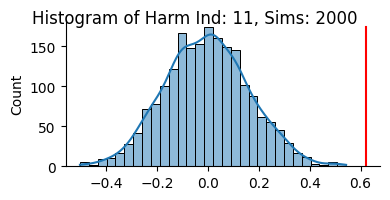

DescribeResult(nobs=2000, minmax=(-0.5792407009059377, 0.6880658480589585), mean=-0.0030128363931346794, variance=0.03910190150559329, skewness=0.041840875411137395, kurtosis=-0.18808264502276684)
SEM:  0.0044216457063854225


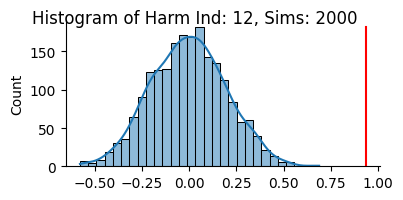

In [41]:
print(real_diff)
sem = dict()
SimValsPerBin = dict() # save differences per harmonic in their respective array
for var in range(NumBins*2):
   SimValsPerBin[var] = pseudo_rca_diffs[:,var]
   print(scipy.stats.describe(SimValsPerBin[var]))
   sem[var] = scipy.stats.sem(SimValsPerBin[var])
   print('SEM: ', sem[var])
   f = sns.displot(SimValsPerBin[var], kde = True, height = 2, aspect = 2)
   plt.axvline(real_diff[var],ymin=0,ymax=0.95, color = 'red')
   f.fig.suptitle(f'Histogram of Harm Ind: {var+1}, Sims: {NumBoots}')
   plt.show()

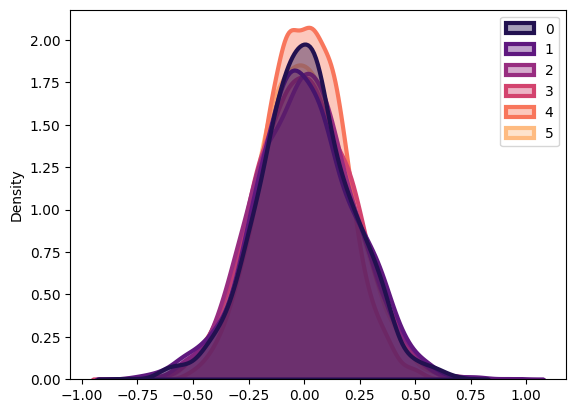

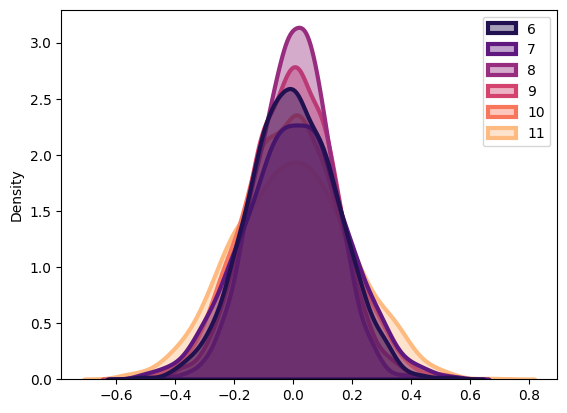

In [91]:
ind_1 = range(0,6)
f2_data = {key: SimValsPerBin[key] for key in ind_1}
ind_2 = range(6,12)
f4_data = {key: SimValsPerBin[key] for key in ind_2}
sns.kdeplot(data = f2_data, fill = True, common_norm = False, palette = 'magma', alpha = 0.40, linewidth = 3)
plt.show()
sns.kdeplot(data = f4_data, fill = True, common_norm = False, palette = 'magma', alpha = 0.40, linewidth = 3)
plt.show()

### Find What Percentile Each Aplitude Difference Lies 

In [92]:
# Combine real amplitude difference in sea of simulated data
SimArrayData = dict()
for m in range(NumBins*2):
    a = real_diff[m]
    s = SimValsPerBin[m] # values generated by Numiters 
    SimArrayData = np.sort(np.append(a,s)) # add real rca diff and sort
    # find position where real_diff number belongs in simulated array ... 
    element_rank = (np.searchsorted(SimArrayData, a)) 
    TotalArrayInds = len(SimArrayData) # all simulated numbers
    percentile = (element_rank / TotalArrayInds) * 100 # multiplier
    print(f'The amplitude difference: {a:.2f} is in the: {percentile:.2f}th percentile.')

    # to find p val subtract by 1   - save p vals into a .pkl file
    # plot p-vals as a distribution or histogram
    # want to know: what % of particiapnts did the response amplitude significantly 
    # increase following ther ltp protocol and was there a bigger effect on F1 vs F2 and 
    # why not, did paying attention to the lfet cause more activity compared to the right?
    # 

The amplitude difference: 0.33 is in the: 93.35th percentile.
The amplitude difference: 0.42 is in the: 96.50th percentile.
The amplitude difference: 0.84 is in the: 99.95th percentile.
The amplitude difference: 0.98 is in the: 99.95th percentile.
The amplitude difference: 0.61 is in the: 99.95th percentile.
The amplitude difference: 0.71 is in the: 99.95th percentile.
The amplitude difference: -0.04 is in the: 40.58th percentile.
The amplitude difference: -0.19 is in the: 13.44th percentile.
The amplitude difference: -0.01 is in the: 45.38th percentile.
The amplitude difference: 0.12 is in the: 80.81th percentile.
The amplitude difference: 0.62 is in the: 99.95th percentile.
The amplitude difference: 0.93 is in the: 99.95th percentile.


### Plot Data to see how the shuffles vary from the real data

In [93]:
x = sns.color_palette("Paired",12)

In [94]:
run_plots = 'N'

if run_plots == 'Y':

#### Plot real CRF data from RCA 
    fig, axs = plt.subplots(2, NumHarms, figsize=(9, 6), sharey = True)
    title = f'Real RCA CRF'
# 2F1
    axs[0,0].plot(real_rca[:6,0], 'o', markersize = 8, label = 'Pre 2F1', color = x[4])
    axs[0,0].plot(real_rca[:6,1], 'o',markersize = 8,  label = 'Post 2F1', color = x[5])
    axs[0,0].legend(fontsize = 7, loc = 'lower right')
    axs[0,0].spines['top'].set_visible(False)
    axs[0,0].spines['right'].set_visible(False)
    axs[0,0].set_ylabel('Response (R)')
    axs[0,0].set_xlabel('Contrast Increase')
# 4F1
    axs[0,1].plot(real_rca[6:,0], 'o',markersize = 8,  label = 'Pre 4F1', color = x[4])
    axs[0,1].plot(real_rca[6:,1], 'o', markersize = 8,  label = 'Post 4F1', color = x[5])
    axs[0,1].legend(fontsize = 7, loc = 'lower right')
    axs[0,1].spines['top'].set_visible(False)
    axs[0,1].spines['right'].set_visible(False)
    axs[0,1].set_ylabel('Response (R)')
    axs[0,1].set_xlabel('Contrast Increase')
    plt.suptitle('Real CRF', fontsize=18)

# plot the difference between pre and post conditions
    plt.show()
else:
    print('Too much data to plot - reduce size or something')

Too much data to plot - reduce size or something


#### Viz for what boot data looks like compared to real data

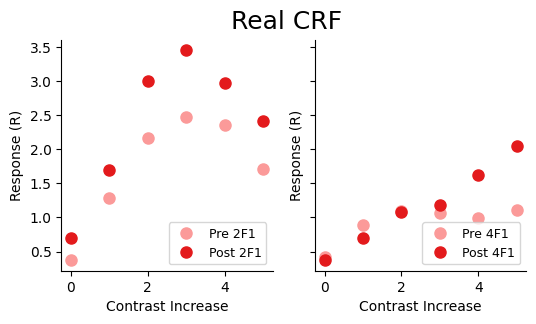

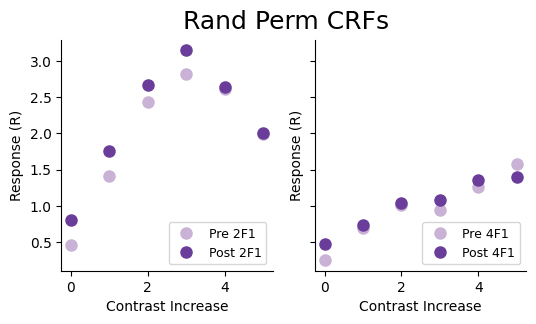

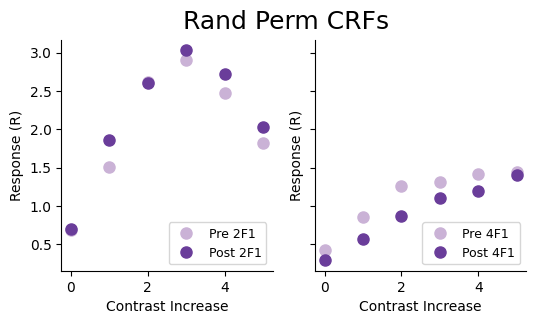

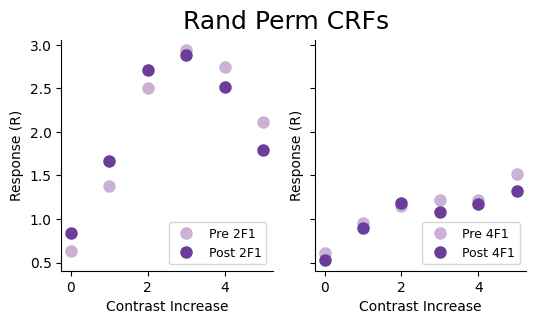

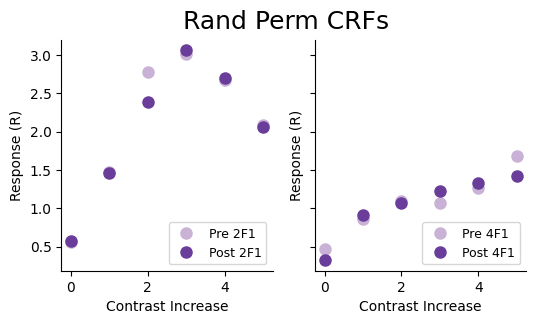

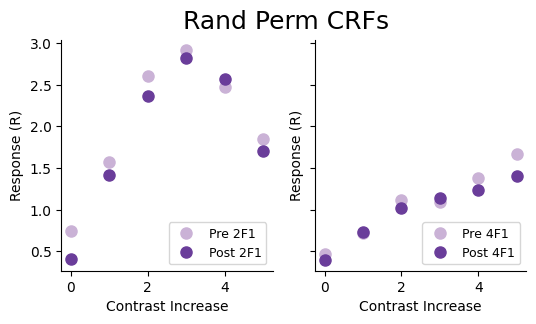

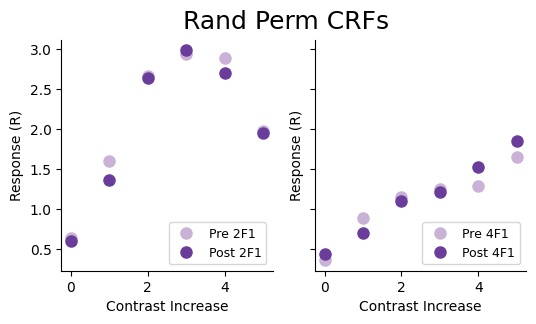

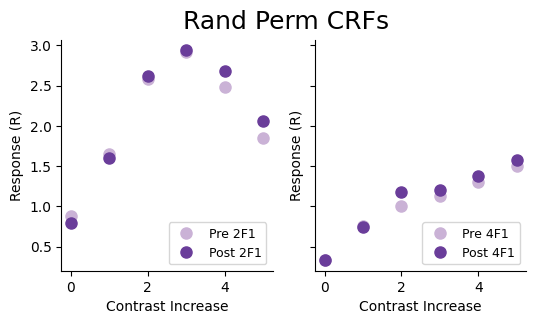

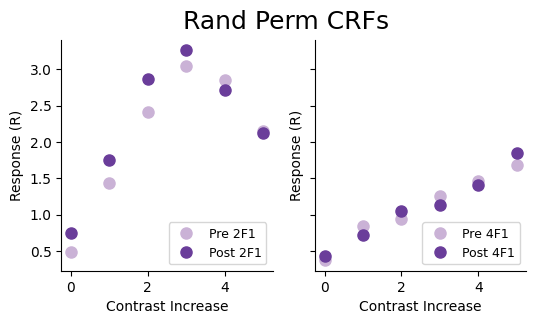

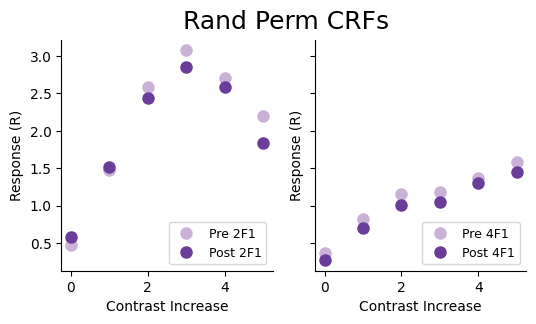

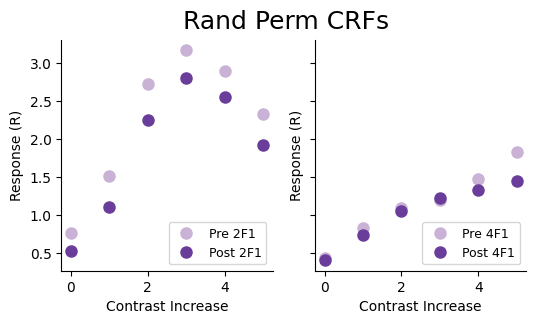

In [95]:
#### Plot real CRF data from RCA 
fig, axs = plt.subplots(1, NumHarms, figsize=(6, 3), sharey = True)
title = f'Real RCA CRF'
# 2F1
axs[0].plot(real_rca[:6,0], 'o', markersize = 8, label = 'Pre 2F1', color = x[4])
axs[0].plot(real_rca[:6,1], 'o',markersize = 8,  label = 'Post 2F1', color = x[5])
axs[0].legend(fontsize = 9, loc = 'lower right')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_ylabel('Response (R)')
axs[0].set_xlabel('Contrast Increase')
# 4F1
axs[1].plot(real_rca[6:,0], 'o',markersize = 8,  label = 'Pre 4F1', color = x[4])
axs[1].plot(real_rca[6:,1], 'o', markersize = 8,  label = 'Post 4F1', color = x[5])
axs[1].legend(fontsize = 9, loc = 'lower right')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_ylabel('Response (R)')
axs[1].set_xlabel('Contrast Increase')
plt.suptitle('Real CRF', fontsize=18)
plt.show()

run_plots = 'Y'

if run_plots == 'Y':
#### Plot generated data from shuffling 
    for iter in range(10):#(len(shuffs.keys())):#(len(rcaData)):
        fig, axs = plt.subplots(1, NumHarms, figsize=(6, 3), sharey = True)
        title = f'F1_SubNumBoots_{iter+1}.png'
    # 2F1 
        axs[0].plot(psuedo_rca[iter][:6,0], 'o', markersize = 8, label = 'Pre 2F1', color = x[8])
        axs[0].plot(psuedo_rca[iter][:6,1], 'o',markersize = 8,  label = 'Post 2F1', color = x[9])
        axs[0].legend(fontsize = 9, loc = 'lower right')
        axs[0].spines['top'].set_visible(False)
        axs[0].spines['right'].set_visible(False)
        axs[0].set_ylabel('Response (R)')
        axs[0].set_xlabel('Contrast Increase')
    # 4F1 
        axs[1].plot(psuedo_rca[iter][6:,0], 'o',markersize = 8,  label = 'Pre 4F1', color = x[8])
        axs[1].plot(psuedo_rca[iter][6:,1], 'o', markersize = 8,  label = 'Post 4F1', color = x[9])
        axs[1].legend(fontsize = 9, loc = 'lower right')
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        axs[1].set_ylabel('Response (R)')
        axs[1].set_xlabel('Contrast Increase')
        plt.suptitle('Rand Perm CRFs', fontsize=18)
        FilePath = os.path.join(SaveFigDir, title)
        plt.savefig(FilePath)
        plt.show()

else:
    print('Will take long ...too much data to plot - fix range() in loop first!!!')

# 10k values and then sort of difference and where is the actual change - to find significant difference
# 1k values - whats mean and std of difference pre and post shuffled - mean of change - but std may be different - f change was different the rca data was - can get p value in terms of std

# get difference btwn simulated and real data and then  - rank the real data placement based on where it lies within the simulated data - will do this 6 times bc of the differnce between pre and post - 

### Preparation for Bootstrapping